# Asset / Portfolio Returns


## Data preparation

There are some data samples we will use in the notebook, in both csv and messagepack formats. To load them, use the helpers provided:

In [1]:
from sample_data import stock_prices
aapl = stock_prices("aapl")
msft = stock_prices("msft")

As some month-end data might be missing (mainly because holidays), we need to pad the series with latest known values:

In [2]:
month_end_prices = msft.Close.resample("M").pad()
month_end_prices[:5]

Date
2010-01-31    28.1800
2010-02-28    28.6700
2010-03-31    29.2875
2010-04-30    30.5350
2010-05-31    25.8000
Freq: M, Name: Close, dtype: float64

We can extract very basic parameters on this serie by using `describe()`

In [3]:
month_end_prices.describe()

count    102.000000
mean      44.929899
std       20.057965
min       23.010000
25%       28.556250
50%       40.400000
75%       55.195000
max      100.860000
Name: Close, dtype: float64

## Asset Returns

Net Return over month $t$ is defined by $R_t = \frac{P_t - P_{t-1}}{P_{t-1}} = \frac{P_t}{P_{t-1}} - 1 = \%\Delta P_{t}$

Intuitively known as the _percentage change in price_.

In [4]:
net_return = msft.Close['2016-03-31'] / msft.Close['2016-02-29'] - 1
net_return

0.08549528301886777

that is equivalent to use `olhc` function we saw in Pandas introduction:

In [5]:
pt = msft.Close['2016-02-01':'2016-03-31'].resample("M").ohlc().close
pt

Date
2016-02-29    50.88
2016-03-31    55.23
Freq: M, Name: close, dtype: float64

In [6]:
net_return = pt[1] / pt[0] - 1
net_return

0.08549528301886777

Pandas already has a function to calculate it, named `pct_change`. For instance, this calculate the net returns for one month:

In [7]:
one_month_net_returns = month_end_prices.pct_change()
one_month_net_returns[:5]

Date
2010-01-31         NaN
2010-02-28    0.017388
2010-03-31    0.021538
2010-04-30    0.042595
2010-05-31   -0.155068
Freq: M, Name: Close, dtype: float64

### Alternative method

Another way to calculate it is using $r_i = \log(\frac{p_i}{p_{i-1}}) = \log{p_i} - \log{p_{i-1}}$

The result is a good approximation for not too big percentage changes. It has the benefit that `log` operations are simple table lookups, so previous division is no longer needed. There're some additional notes on the math behind in [this answer from StackExchange](https://stats.stackexchange.com/questions/244199/why-is-it-that-natural-log-changes-are-percentage-changes-what-is-about-logs-th).

For this implementation we'll be using [`shift` method from Pandas' Series](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.shift.html), that returns the previous element in the sequence.

In [8]:
import numpy as np

def monthly_returns(closes):    
    return np.log(closes) - np.log(closes.shift(1))

returns = monthly_returns(month_end_prices)
returns[:5]

Date
2010-01-31         NaN
2010-02-28    0.017239
2010-03-31    0.021310
2010-04-30    0.041713
2010-05-31   -0.168499
Freq: M, Name: Close, dtype: float64

### K-Month Generalization

Beware of adding two simple one-period returns. Having $R_{t-1} = 0.5$ and $R_t = -0.5$ gives a two-period return of zero, but it should be $R_t(2) - 1 = (1.5 \cdot 0.5) - 1 = -0.25$.

Better to generalize it as:

$1 + R_t(k) = \prod{1 + R_{t-j}}$ 

For instance, the geometric average of two one-month returns, March and April, are:

In [9]:
rt2 = ((returns[3] - 1) * (returns[4] - 1)) - 1
rt2

0.1197577499624396

## Portfolio Returns

The same values we've calculated before for assets can easily be translated to whole _portfolios_.

Let's calculate the initial portfolio value and the amount of shares

In [10]:
msft_shares = 10
aapl_shares = 10
initial_portfolio_value = (msft_shares * msft.Close['2016-03-30']) + (aapl_shares * aapl.Close['2016-03-30'])
initial_portfolio_value

1646.1

Percentage of each stock, should add to 1

In [11]:
x_msft = (msft_shares * msft.Close['2016-03-30']) / initial_portfolio_value
x_aapl = (aapl_shares * aapl.Close['2016-03-30']) / initial_portfolio_value
[x_msft, x_aapl, x_msft+x_aapl]

[0.3344268270457445, 0.6655731729542554, 1.0]

One-month returns for AAPL and MSFT

In [12]:
ret_msft = msft.Close['2016-04-29'] / msft.Close['2016-03-30'] - 1
ret_aapl = aapl.Close['2016-04-29'] / aapl.Close['2016-03-30'] - 1
[ret_msft, ret_aapl]

[-0.09409627611262483, -0.14439576487769268]

You can see them as _weights_. Using them, the one-month rate of return on the portfolio is

In [13]:
rpt = (x_msft*ret_msft) + (x_aapl*ret_aapl)
rpt

-0.12757426644796796

The portfolio value at the end of month $t$ is $V_t = V_{t-1}(1 + R_{p,t})$

In [14]:
vt = initial_portfolio_value * (1 + rpt)
vt

1436.1

In general, for a portfolio of $n$ assets with investment shares $x_i$ such that $x_1+...+x_n=1$, the one-period portfolio gross and simple returns are defined as

$R_{p,t} = \sum\limits_{i=1}^n x_i R_{i,t}$

## Basic Parameters: Volatility

The _Volatility_ of a stock gives us a measure on the amount of uncertainty given the changes made over time. Normally, it is computed using the standard deviation over the logaritmic returns.

The daily volatility for a given period of returns $P$ can be defined as:

$\sigma _{\text{P}}=\sigma _{\text{daily}}{\sqrt{P}}$

Therefore, to calculate the volatily for one month, we just have to compute the standard deviation over the returns of that month, having $P$ trading days:

In [15]:
from math import sqrt

time_slice = msft.Close['2016-03-30':'2016-04-29']
std_dev_returns = time_slice.pct_change().std()
trading_days = len(time_slice)

volatility = std_dev_returns * sqrt(trading_days)
volatility

0.08540735600279344

This gives us notion on how far the price might deviate from the average, in this case a 8.54%.

## Basic Parameters: Moving Average

_Moving Average_ (MA) is an indicator that constantly describes the average price over a period. It's also called _rolling average_. The mean over the last $k$ data points can be calculated as:

${\begin{aligned}{\textit {SMA}}_{k}={\frac {p_{n-k+1}+p_{n-k+2}\cdots +p_{n}}{k}}={\frac {1}{k}}\sum _{i=n-k+1}^{n}p_{i}\end{aligned}}$

Luckily, Pandas comes with batteries included, offering us the `.rolling()` function

In [16]:
ma50 = msft.Close.rolling(50).mean()
ma200 = msft.Close.rolling(200).mean()

Using that, we can plot to observe trends:

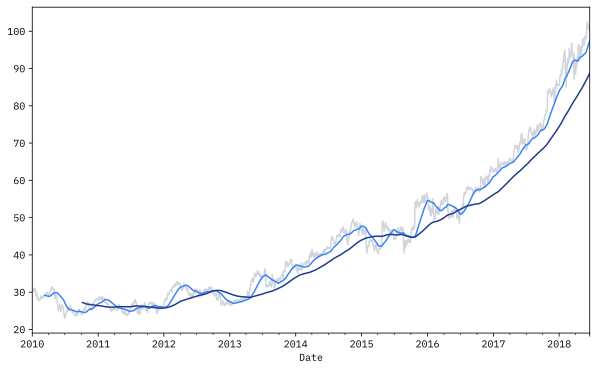

In [17]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['font.family'] = "IBM Plex Mono"

ig, ax = plt.subplots(figsize=(10,6))

msft.Close.plot(color='#D1D5DB')
ma50.plot(color='#3B82F6')
ma200.plot(color='#1E3A8A')
plt.show()

A variation of this is to use the _Exponential Moving Average (EMA)_, that gives more weight to recent prices. Again, Pandas offers us the `.ewm` function to calculate it.

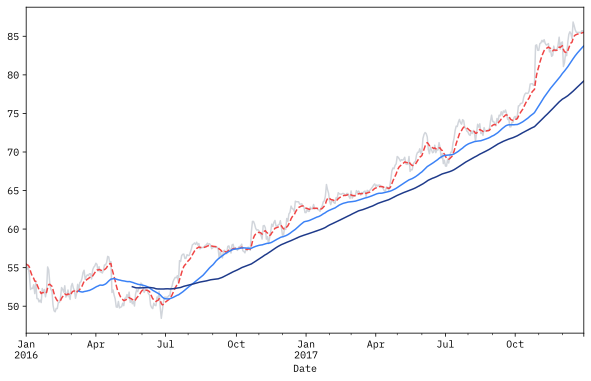

In [18]:
msft_2016 = msft['2016':'2017']
ema10 = msft_2016.Close.ewm(span=10, adjust=False).mean()
sma50 = msft_2016.Close.rolling(50).mean()
sma100 = msft_2016.Close.rolling(100).mean()

ig, ax = plt.subplots(figsize=(10,6))

msft_2016.Close.plot(ax=ax, color='#D1D5DB')
ema10.plot(ax=ax, color='#EF4444', linestyle="--")
sma50.plot(ax=ax, color='#3B82F6')
sma100.plot(ax=ax, color='#1E3A8A')
plt.show()

SMA represent the average of prices in a timespan, and are better suited to identify "resistance" levels. In contrast, EMA has less lag and are therefore more sensitive to recent prices.

### MACD

There's another indicator called _Moving Average Convergence/Divergence oscillator (MACD)_. It's calculated by getting two moving averages and substracting the longer moving average by the sorter one. In the calculated MCDA below, negative MACD values indicate that the 12-day EMA is below the 26-day EMA.

In [19]:
ema12 = msft_2016.Close.ewm(span=12, adjust=False).mean()
ema26 = msft_2016.Close.ewm(span=26, adjust=False).mean()
macd = ema12 - ema26
macd

Date
2016-01-01    0.000000
2016-01-04   -0.054245
2016-01-05   -0.076183
2016-01-06   -0.172276
2016-01-07   -0.395570
                ...   
2017-12-25    0.860086
2017-12-26    0.809556
2017-12-27    0.785470
2017-12-28    0.758446
2017-12-29    0.714271
Name: Close, Length: 521, dtype: float64

Additionally, we can calculate a _signal line_ that would identify events on the MACD when both lines cross. When signal line is below the MACD, things are improving over time.

<AxesSubplot:xlabel='Date'>

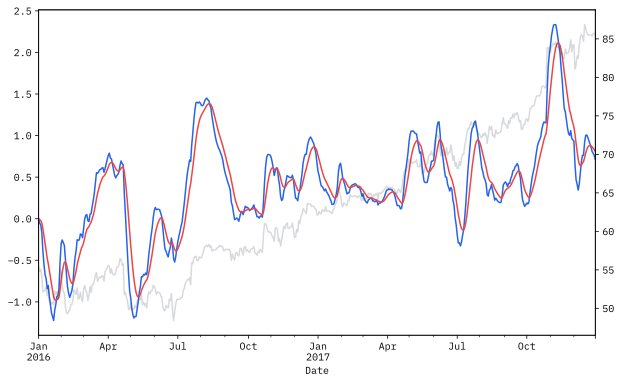

In [20]:
signal = macd.ewm(span=9, adjust=False).mean()

fig, ax = plt.subplots(figsize=(10,6))
msft_2016.Close.plot(ax=ax, color='#374151', alpha=0.2, secondary_y=True)
macd.plot(ax=ax, color='#2563EB')
signal.plot(ax=ax, color='#EF4444')